# Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import imghdr
import tensorflow as tf
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

# Define Project Directory

Before proceeding, let's set up the project directory. We'll mount Google Drive to access our project files, define the directory path for the image classification project, and specify the data path where the images to be processed are located.

In [ ]:
# mounting to google drive
drive.mount('/gdrive')

In [ ]:
dir = '/content/drive/MyDrive/Python and Machine Learning Practice/End to End ML Practice/Happy and Sad Image Classification'
data_dir = os.path.join(dir, 'data')

# Remove Dodgy Image from Dataset

To maintain data integrity, we will establish a list of permitted image extensions, including .jpg, .jpeg, .png, and .bmp. Sebsequently, we will filter the images within the data directory based on these allowed extensions, discarding any with incompatible formats.

In [ ]:
# define the list of allowed image extentions
img_exts = ['jpg', 'jpeg', 'png', 'bmp']

In [ ]:
# filter images in the data directory based on allowed extensions

for image_class in os.listdir(data_dir):
  image_class_path = os.path.join(data_dir, image_class)
  for image in os.listdir(image_class_path):
    image_path = os.path.join(image_class_path, image)
    try:
      img_ext = imghdr.what(image_path)
      if img_ext not in img_exts:
        print(f'{image_path} extention is not in extentions list')
        os.remove(image_path)
    except Exception as e:
      print(f'{image_path} has an issue')

# Load Data


In [ ]:
# load the dataset from the data directory
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 171 files belonging to 2 classes.


In order to stramline accessibility and facilitate the handling of the image dataset, we will convert data into Numpy iterator type. This conversion aims to enhance ease of use during subsequent stages of the project.

In [ ]:
# convert the image dataset to numpy iterator
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

In [ ]:
f'Batch size: {batch[0].shape}, maximum value:{batch[0].max()}, minimum value:{batch[0].min()}'

'Batch size: (32, 256, 256, 3), maximum value:255.0, minimum value:0.0'

Based on the provided information, our data batches consist of 32 images, each with a size of 256x256 pixels and 3 channels. The pixel values range from a minimum of 0 to a maximum of 255.


# Normalize Image Data

To normalize the image data, we will scale the pixel values to the range of 0-1. This involves deviding each numpy value by its maximum value (255). This normalization process ensures consistent and efficient data representation in our machine learning model.

In [ ]:
# rescale image intensity to the range 0-1
scaled_data = data.map(lambda x, y: (x/255, y))

In [ ]:
# verify normalized data scale
scaled_data_batch = scaled_data.as_numpy_iterator().next()
print(f'maximum scaled data pixel: {scaled_data_batch[0].max()}, minimum scalec data pixel: {scaled_data_batch[0].min()}')

maximum scaled data pixel: 1.0, minimum scalec data pixel: 0.0


# Displaying Sample Image

To confirm the accuracy of labels associated with respective images, let's showcase a selection of sample images.

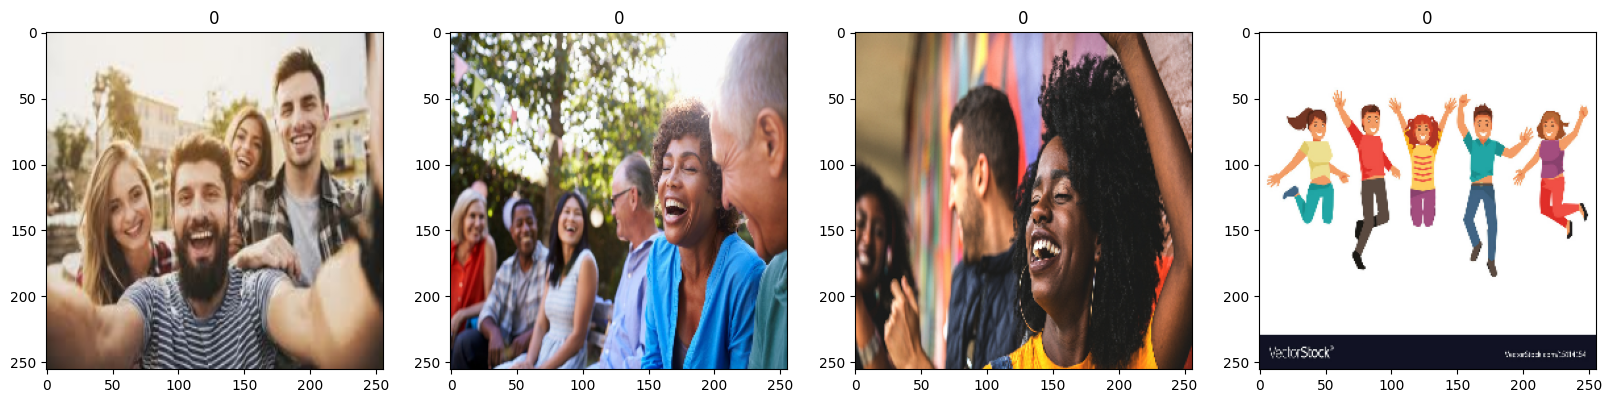

In [ ]:
# Displaying Sample Images for Label Verification
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(scaled_data_batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(scaled_data_batch[1][idx])

Upon inspecting the displayed images, it is evident that images belonging to the "happy" class are labeled as 0, while those from the "sad" class are labeled as 1.

# Data Splitting

For effective model training and evaluation, we will divide the dataset into three subsets:

- Training Dataset: 70%
- Validation Dataset: 20%
- Test Dataset: 10%

In [ ]:
# define data length
data_length = len(data)

In [ ]:
# define data train, valid, and test size
train_size = int(data_length*.7)
valid_size = int(data_length*.2)
test_size = int(data_length*.1)+1

In [ ]:
# verify batch counts in each data subset
f'train data has {train_size} batch, validation data has {valid_size}, test data has {test_size}'

'train data has 4 batch, validation data has 1, test data has 1'

In [ ]:
# data splitting
train = scaled_data.take(train_size)
valid = scaled_data.skip(train_size).take(valid_size)
test = scaled_data.skip(train_size+valid_size).take(test_size)

# Modeling

## Built Deep Learning Model

In [ ]:
# constract the fondation of the deep learning model

model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

## Train Model

To facilitate model monitoring and visualization, we configure a TensorBoard callback. The log directory ('logs) is extablished within the project directory, ensuring integration with TensorBoard for tracking and analysis

In [ ]:
# tensorBoard callback configuration
logdir = os.path.join(dir, 'logs')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
# model training
hist = model.fit(train, epochs=20, validation_data=valid, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 14s 1s/step - loss: 1.1854 - accuracy: 0.6094 - val_loss: 0.8522 - val_accuracy: 0.4062
Epoch 2/20
4/4 [==============================] - 7s 2s/step - loss: 0.7609 - accuracy: 0.4922 - val_loss: 0.7057 - val_accuracy: 0.4688
Epoch 3/20
4/4 [==============================] - 6s 1s/step - loss: 0.5943 - accuracy: 0.6094 - val_loss: 0.6003 - val_accuracy: 0.5625
Epoch 4/20
4/4 [==============================] - 8s 2s/step - loss: 0.5225 - accuracy: 0.6719 - val_loss: 0.5731 - val_accuracy: 0.5312
Epoch 5/20
4/4 [==============================] - 6s 1s/step - loss: 0.4833 - accuracy: 0.6875 - val_loss: 0.4613 - val_accuracy: 0.8750
Epoch 6/20
4/4 [==============================] - 8s 2s/step - loss: 0.4502 - accuracy: 0.8203 - val_loss: 0.4771 - val_accuracy: 0.7812
Epoch 7/20
4/4 [==============================] - 6s 999ms/step - loss: 0.3475 - accuracy: 0.8516 - val_loss: 0.3154 - val_accuracy: 0.9062
Epoch 8/20
4/4 [=====================

## Model Performance Visualization

Plot the training and validation loss and accuracy over epochs to evaluate the model's overall performance

In [ ]:
history_list = list(hist.history.keys())
history_list

['loss', 'accuracy', 'val_loss', 'val_accuracy']

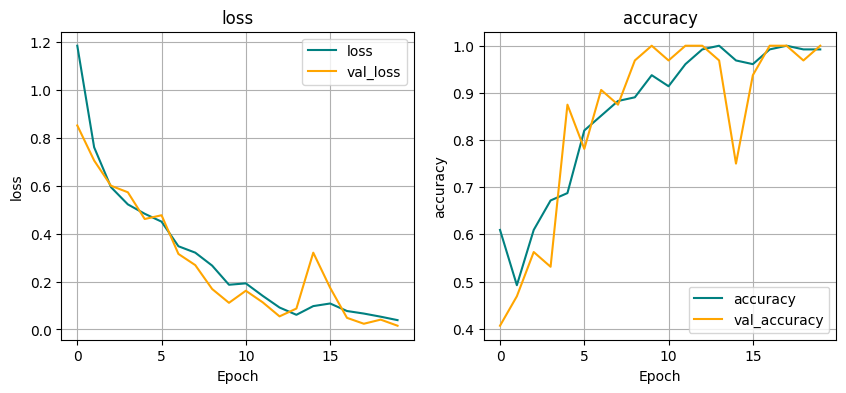

In [ ]:
# loss and accuracy visualization
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for idx, metric in enumerate(history_list[:2]):
  ax[idx].plot(hist.history[metric], color='teal', label=metric)
  ax[idx].plot(hist.history[history_list[idx+2]], color='orange', label='val_'+metric)
  ax[idx].set_title(metric)
  ax[idx].set_xlabel('Epoch')
  ax[idx].set_ylabel(metric)
  ax[idx].grid(True)
  ax[idx].legend()

plt.show()

Based on the graphical representation of the model performance, it is observed that the trained model achieves remarkable results:

- Loss: 0
- Accuracy: 100%

These metrics indicate a highly successful training process, showcasing optimal model performance.

# Evaluate Model Performance

To comprehensively assess the overall model performance, we will examine models's precision, recall, and  accuracy metrics when appied to the test dataset. This evaluation provides more detailed understanding of the model's effectiveness across various performance indicators.

In [ ]:
# initialize precision, recall, and binary accuracy metrics
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
# predict test data using trained model
for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)

1/1 [==============================] - 0s 385ms/step


In [ ]:
# update precision, recall, and binary accuracy metrics with true and predicted values
pre.update_state(y, yhat)
re.update_state(y, yhat)
acc.update_state(y, yhat)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=11.0>

In [ ]:
f'Precision : {pre.result()}, Recall : {re.result()}, Accuracy : {acc.result()}'

'Precision : 1.0, Recall : 1.0, Accuracy : 1.0'

The precision, recall, and accuracy scores signify the model's ability to make accurate predictions with complete precision and recall on the given test data.

## Testing the Model with External Images

To assess the model's generalization capability, we will directly test it using images not present in the dataset.

In [ ]:
def predict_image_label(img_dir):
  # read image
  img = cv2.imread(img_dir)

  # display image
  img_color = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  plt.imshow(img_color)
  plt.show()

  # preprocessing image
  resize_img = tf.image.resize(img, (256,256))
  scale_img = resize_img/255
  batch_img = np.expand_dims(scale_img, 0)

  # predict image
  yhat = model.predict(batch_img)

  if yhat < 0.5:
    print('This image is belong to happy')
  else:
    print('This image is belong to sad')

To facilitate the testing trained model on external images, a custon function 'predict_image_label' has been created. This functiontakes the image directory as input, reads the image, and displays it using OpenCV ans Matplotlib. Subsequently, the image undergoes preprocessing, involving resizing to 256x256 pixels, scaling pixel values to the range of 0-1, and adding batch dimension.

The processed image is then fed into the model for prediction. if the prediccted probability is less than 0.5, the image is classified as "happy"; otherwise, it is categorized as "sad". This function serves as a practical tool to evaluate the model's performance on new and unseen images.

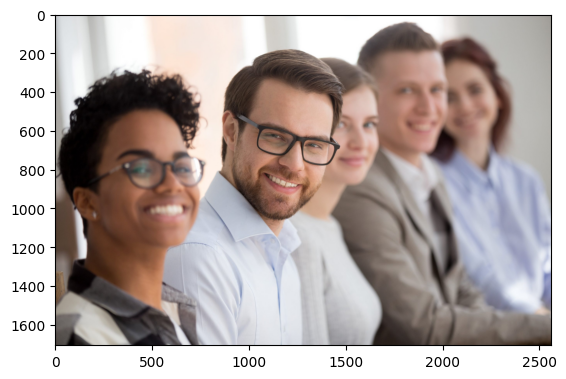

1/1 [==============================] - 0s 205ms/step
This image is belong to happy


In [ ]:
# define happy test image directory
happy_test_img_dir = os.path.join(dir, 'test_img_happy.jpg')

# predict a label for happy test image
predict_image_label(happy_test_img_dir)

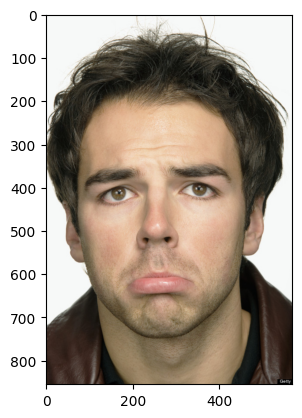

1/1 [==============================] - 0s 19ms/step
This image is belong to sad


In [ ]:
# define happy test image directory
sad_test_img_dir = os.path.join(dir, 'test_img_sad.jpg')

# predict a label for sad test image
predict_image_label(sad_test_img_dir)

The testing of the model on an external image has been successfully executed, yielding accurate label predictions that align with the content of the input image. This outcome underscores the model's ability to generalize and make reliable predictions on unseen data, showcasing its effectiveness in real-world applications.

# Save Model

In [ ]:
# define the directory where the trained model will be saved
model_dir = os.path.join(dir, 'model', 'happysadmodel.h5')

In [ ]:
# save the .h5 model to the directory
model.save(model_dir)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
